# Travail de PHYS-F-30

In [174]:
import numpy as np
import matplotlib.pyplot as plt

## Présentation

Le but de ce notebook est de calculer le flot dans une cavité cubique en résolvant une équation biharmonique. Commençons par retracer le raisonnement qui nous conduit à cette équation. Nous avons tout d'abord les équations de Navier-Stokes pour un fluide incompressible.

$$
\frac{\partial u}{\partial t} + u \cdot \nabla u = -\frac{1}{\rho}\nabla p + \nu\nabla^2 u
$$

Nous rendons ensuite ceci adimensionnel de manière à faire apparaître le nombre de Reynolds, 
\begin{equation}
Re \left(\frac{\partial u^*}{\partial t} + u^* \cdot \nabla u^* \right) = -\nabla p^* + \nabla^2 u^*
\end{equation}

où $u^*$ et $p^*$ sont les vitesses et pressions adimensionnelles.

Notre problème se concentre sur des fluides ayant un nombre de Reynolds extrêment petit $Re \ll 1$, c'est-à-dire très lent et visqueux à l'échelle microscopique. Ceci nous permet de grandement simplifier l'équation ci-dessus. En effet, on voit qu'avec cette supposition, le membre de gauche de la seconde équation est proche de zéro de manière à se ramener à (en enlevant les stars)
$$
0 = - \nabla p + \nabla^2 u
$$

En appliquant maintenant l'opérateur rotationnel dans chaque membre, nous définition la fonction de courant $\omega$ comme
$$
\nabla \times \nabla^2 u =\nabla^2\omega
$$
où $\nabla \times u = \omega$ est la vorticité (pas sûr de la traduction). Ceci nous permet d'obtenir finalement l'équation de transport de vorticité pour le flot de Stokes.

$$\nabla ^2 \omega = 0$$

Il est possible d'aller encore plus loin dans notre simplification. En effet, en posant 

\begin{equation}
u = \frac{\partial \varphi}{\partial y} \quad \text{et} \quad v = - \frac{\partial \varphi}{\partial x}
\end{equation}

Nous avons de plus, à deux dimensions
$$
\omega = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}
$$

ce qui, combiné aux équations précédentes, nous donne
$$
\nabla^2 \varphi = -\omega
$$

En remplaçant ceci, dans une équation précédente nous trouvons (enfin) notre équation


$$\nabla^4 \varphi =  {\displaystyle {\frac {\partial ^{4}\varphi }{\partial x^{4}}} + {\frac {\partial ^{4}\varphi }{\partial y^{4}}} + 2{\frac {\partial ^{4}\varphi }{\partial x^{2}\partial y^{2}}} = 0} 
$$

qui se trouve être une équation biharmonique à deux dimensions que nous pouvons résoudre à l'aide de la méthode des gradients conjugués.

Dans notre problème, les conditions aux bords sont données telles que la fonction $\varphi$ soit nulle sur les bords ainsi que sa dérivée, exceptée sur le bord supérieur où sa dérivée est égale à 1. 

Notre problème se résume comme suit: une cavité cubique (nous travaillons, nous, à deux dimensions par soucis de simplicité) est remplie avec un fluide à petit nombre de Reynolds. Nous faisons ensuite glisser le convercle de cette cavité à vitesse constante ($\partial_y \varphi (i, ny) = 1$). Ceci induit un mouvement dans le fluide que nous allons tenter de modéliser. Les conditions aux bords ne sont donc que là que pour exprimer le fait que le fluide reste statique sur le bords (le nombre de Reynolds étant petit, le fluide est extrêmement visqueux et donc reste accroché à la paroie) excepté le supérieur qui accompagne le mouvement du couvercle.


## Discrétisation et résolution

In [175]:
nx = 41  #Nombre de step en X
ny = 41  #Nombre de step en Y

l = 1. #Longueur de la boite
h = 1. #Hauteur de la boite

dx = l/(nx-1) #taille du step infinitésimal en X
dy = h/(ny-1) #taille du step infinitésimal en Y

#On prend la norme L1 pour vérifier la convergence de notre algorithme
def L1norm(new, old):
    norm = np.sum(np.abs(new-old))
    return norm

p0 = np.zeros((nx, ny)) #Première itération de p dans les gradients conjugués

l1_target = 1e-8  #Limite de convergence

Nous allons tout d'abord discrétiser l'équation biharmonique. En utilisant le [lien](https://www.structville.com/2017/05/application-of-finite-difference-method.html) ci-joint, nous avons une équation biharmique discrétisée à l'aide des différences finies centrées d'ordre 2,

$$[\nabla^4 \varphi]_{i, j} = 20 \varphi_{i,j} - 8(\varphi_{i-1,j} + \varphi_{i,j-1} + \varphi_{i,j + 1} + \varphi_{i + 1,j}) + 2(\varphi_{i-1,j-1} + \varphi_{i-1,j + 1} + \varphi_{i + 1,j - 1} + \varphi_{i + 1,j + 1}) + (\varphi_{i-2,j} + \varphi_{i,j-2} + \varphi_{i,j+ 2} + \varphi_{i+ 2,j}) = 0$$

Nous pouvons voir notre problème comme suit $A\varphi = 0$ où la matrice $A$ est une matrice à 4 dimensions s'appliquant sur la matrice $\varphi$ (qui est de taille $41\times 41$). Il se trouve que la matrice $A$ s'appliquant à $\varphi$ construite comme ci-dessus ne peut pas résoudre l'intégralité de notre problème. En effet, les conditions aux bords ne sont pas prises en comptes ici, notre matrice $A$ ne se soucie que de l'intérieur de notre $\varphi$ (pour appliquer cette matrice, on doit enlever les deux premières et dernières lignes et colonnes, donc $A$ s'applique sur une matrice $(nx-4)\times(ny-4)$). Les conditions aux bords vont modifier les valeurs de notre matrice $A$ et vont, de plus, imposer une valeur de $b$ telle que $A\varphi = b$.

En utilisant le [lien](https://en.wikipedia.org/wiki/Finite_difference_coefficient) wikipedia sur les différences finies, nous pouvons alors discrétiser nos conditions aux bords à l'aide des dérivées forward et backward tel que

\begin{align}
    -3/2\varphi_{0, j} + 2\varphi_{1, j} - 1/2\varphi_{2, j} &= 0, \\
    -3/2\varphi_{i, 0} + 2\varphi_{i, 1} - 1/2\varphi_{i, 2} &= 0, \\
    3/2\varphi_{nx, j} - 2\varphi_{nx-1, j} + 1/2\varphi_{nx-2, j} &= 0, \\
    3/2\varphi_{i, ny} - 2\varphi_{i, ny-1} + 1/2\varphi_{i, ny-2} &= \Delta y.
\end{align}

Avec ceci, combinons le fait que $\varphi_{nx,j} = \varphi_{i, ny} = \varphi_{0,j} = \varphi_{i, 0} = 0$, pour obtenir
\begin{align}
    \varphi_{1, j} &= \varphi_{2, j}/4  \\
    \varphi_{i, 1} &= \varphi_{i, 2}/4  \\
    \varphi_{nx-1, j} &= \varphi_{nx-2, j}/4  \\
    \varphi_{i, ny-1}  &= \varphi_{i, ny-2}/4 - \Delta y/2
\end{align}

En remplaçant ceci dans $A\varphi = 0$ nous allons pouvoir déterminer notre $b$. Explicitons ce $b$. Nous avons
\begin{align}
[\nabla^4 \varphi]_{i, ny-2} &= 20 \varphi_{i,ny - 2} - 8(\varphi_{i-1,ny - 2} + \varphi_{i,ny - 3} + \varphi_{i,ny - 1} + \varphi_{i + 1,ny - 2}) + 2(\varphi_{i-1,ny - 3} + \varphi_{i-1,ny - 1} + \varphi_{i + 1,ny - 3} + \varphi_{i + 1,ny - 1}) + (\varphi_{i-2,ny - 2} + \varphi_{i,ny - 4} + \varphi_{i,ny} + \varphi_{i+ 2,ny - 2}) \\
&= 20 \varphi_{i,ny - 2} - 8(\varphi_{i-1,ny - 2} + \varphi_{i,ny - 3} + \varphi_{i, ny-2}/4 - \Delta y/2 + \varphi_{i + 1,ny - 2}) + 2(\varphi_{i-1,ny - 3} + \varphi_{i-1, ny-2}/4 + \varphi_{i + 1,ny - 3} + \varphi_{i + 1, ny-2}/4 - \Delta y) + (\varphi_{i-2,ny - 2} + \varphi_{i,ny - 4} + \varphi_{i+ 2,ny - 2}) = 0
\end{align}

En isolant les $\Delta y$ de l'autre côté de l'égalité, nous trouvons une condition du type $[\nabla^4 \varphi]_{i, ny-2} = -2\Delta y$. De manière similaire, 
\begin{align}
[\nabla^4 \varphi]_{i, ny-3} &= 20 \varphi_{i,ny - 3} - 8(\varphi_{i-1,ny - 3} + \varphi_{i,ny - 4} + \varphi_{i,ny - 2} + \varphi_{i + 1,ny - 3}) + 2(\varphi_{i-1,ny - 4} + \varphi_{i-1,ny - 3} + \varphi_{i + 1,ny - 4} + \varphi_{i + 1,ny - 2}) + (\varphi_{i-2,ny - 3} + \varphi_{i,ny - 5} + \varphi_{i,ny-1} + \varphi_{i+ 2,ny - 3}) \\
&=  20 \varphi_{i,ny - 3} - 8(\varphi_{i-1,ny - 3} + \varphi_{i,ny - 4} + \varphi_{i,ny - 2} + \varphi_{i + 1,ny - 3}) + 2(\varphi_{i-1,ny - 4} + \varphi_{i-1,ny - 3} + \varphi_{i + 1,ny - 4} + \varphi_{i + 1,ny - 2}) + (\varphi_{i-2,ny - 3} + \varphi_{i,ny - 5} + \varphi_{i, ny-2}/4 - \Delta y/2 + \varphi_{i+ 2,ny - 3}) = 0
\end{align}

En isolant, on trouve une égalité du type $[\nabla^4 \varphi]_{i, ny-3} = \Delta y /2$. Comme la matrice $[\nabla^4 \varphi]_{i, j}$ n'est définie que pour $i,j = 2, \ldots, nx (\text{ou } ny) - 2$, il n'y a plus d'autres cas à considérer. Toutes les autres égalités ne feront pas apparaître de terme en $\Delta y$. Nous pouvons donc maintenant expliciter nos matrices $A\varphi$ et $b$. 

In [176]:
#On explicite la matrice b discutée ci-dessus
b = np.zeros((nx, ny))
b[-3, 2:-2] = -np.ones((ny-4))*dy*2
b[-4, 2:-2] = np.ones((ny-4))*dy/2

#On explicite la matrice A discutée ci-dessus
def A(p):
    A_p = np.copy(p)
    A_p[2:-2, 2:-2] = (20*p[2:-2, 2:-2] - 8*(p[1:-3, 2:-2] + p[2:-2, 1:-3] + p[3:-1, 2:-2] + p[2:-2, 3:-1])
                       + 2*(p[1:-3, 1:-3] + p[1:-3, 3:-1] + p[3:-1, 1:-3] + p[3:-1, 3:-1]) 
                       + (p[:-4, 2:-2] + p[2:-2, :-4] + p[2:-2, 4:] + p[4:, 2:-2])) 
    return A_p

Nous avons maintenant tout en main pour résoudre notre problème à l'aide de l'algorithme des gradients conjugués donné dans le MOOC. Notons que notre matrice $A$ explicitée ci-dessus ne tient pas compte des conditions aux bords, nous les rajoutons donc manuellement.

In [177]:
# Etant donné que la quasi totalité de cet algorithme vient du MOOC, les commentaires sont en anglais. Les commentaires 
# que nous avons ajouté sont donc également en anglais, nous vous prions de nous excuser pour les éventuelles erreurs de language.

def biharm_2d_conjugate_gradient(p0, b, dx, dy, maxiter=10000, rtol=1e-8):
    p = p0.copy()
    r = np.zeros_like(p)  # initial residual
    conv = []  # convergence history
    diff = rtol + 1  # initial difference
    ite = 0  # iteration index
    
    # Compute the initial residual with A(p0) = 0
    r = b - A(p)
    
    # Set the initial search direction to be the residual.
    d = r.copy()
    
    
    
    while diff > rtol and ite < maxiter:
        pk = p.copy()
        rk = r.copy()

        
        # Compute the Laplacian of the search direction
        Ad = A(d)
        
        
        # Compute the step size.
        # We apply the boundery conditions on d, Ad and r such that alpha take into account the rows and columns 
        # 1,j ; i,1 ; nx-1,j ; i,ny-1 (in the sum; np.sum(...)) with the right boundery conditions 
        d[1:-1, 1] = d[1:-1, 2]/4
        d[1, 1:-1] = d[2, 1:-1]/4
        d[1:-1, -2] = d[1:-1, -3]/4 
        d[-2, 1:-1] = d[-3, 1:-1]/4
        
        Ad[1:-1, 1] = Ad[1:-1, 2]/4
        Ad[1, 1:-1] = Ad[2, 1:-1]/4
        Ad[1:-1, -2] = Ad[1:-1, -3]/4 
        Ad[-2, 1:-1] = Ad[-3, 1:-1]/4
        
        r[1:-1, 1] = r[1:-1, 2]/4
        r[1, 1:-1] = r[2, 1:-1]/4
        r[1:-1, -2] = r[1:-1, -3]/4 
        r[-2, 1:-1] = r[-3, 1:-1]/4
        
        alpha = np.sum(r * r)/np.sum(d * Ad)
        
        # Update the solution.
        p = pk + alpha * d
        
        
        # Update the residual.
        r = rk - alpha * Ad
        
        
        # We apply the boundery conditions for the same reason as for the calculation of alpha (but now for beta)
        r[1:-1, 1] = r[1:-1, 2]/4
        r[1, 1:-1] = r[2, 1:-1]/4
        r[1:-1, -2] = r[1:-1, -3]/4 
        r[-2, 1:-1] = r[-3, 1:-1]/4
    
    
        # Update the search direction.
        beta = np.sum(r * r)/np.sum(rk * rk)
        d = r + beta * d
        
        
        # Compute the relative L1-norm of the difference.
        diff = L1norm(p, pk)
        conv.append(diff)
        ite += 1
    
    # We apply one last time the true boundery condition on p 
    p[1:-1, 1] = p[1:-1, 2]/4
    p[1, 1:-1] = p[2, 1:-1]/4
    p[1:-1, -2] = p[1:-1, -3]/4 
    p[-2, 1:-1] = p[-3, 1:-1]/4 - dy/2
        
    return p, ite, conv

data = biharm_2d_conjugate_gradient(p0, b, dx, dy, rtol=l1_target)

In [178]:
print("La valeur de la stream function en (0.6,0.2) est", data[0][8,24])
print("La valeur de la stream function en (0.6,0.2) est", data[0][16,24])
print("La valeur de la stream function en (0.6,0.2) est", data[0][24,24])
print("La valeur de la stream function en (0.6,0.2) est", data[0][32,24])

La valeur de la stream function en (0.6,0.2) est -0.008816388769221804
La valeur de la stream function en (0.6,0.2) est -0.0317559109867288
La valeur de la stream function en (0.6,0.2) est -0.06482290509608818
La valeur de la stream function en (0.6,0.2) est -0.08298247174499486


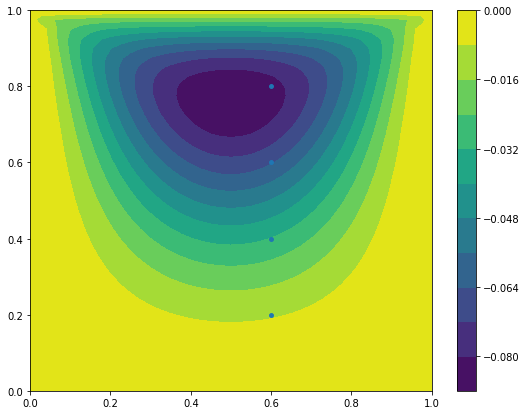

In [179]:
x_points = np.ones(4)*0.6
y_points = np.array([0.2, 0.4, 0.6, 0.8])

x = np.linspace(0, l, nx)
y = np.linspace(0, h, ny)
X,Y = np.meshgrid(x, y)
Z = data[0]

fig, axes = plt.subplots(figsize = (9, 7))
surf = plt.contourf(X, Y, Z,10, cmap=cm.viridis)
plt.scatter(x_points, y_points, s = 15) #Liste des points demandés plus haut
fig.colorbar(surf);